In [78]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import pretty_midi
import warnings
import IPython.display as ipd
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import librosa, librosa.display 
from ipywidgets import IntSlider, FloatSlider, fixed, Checkbox
from ipywidgets import interactive_output
from ipywidgets import VBox, Label
from mido import MidiFile
import seaborn as sns
from music21.tempo import MetronomeMark   
from music21.note import Note, Rest
from music21.stream import Stream
from music21 import metadata
from music21 import instrument
from music21 import midi 
from music21.key import Key

## Step 1: Loading the Data

Loading the genre label

Link to download the cls dataset:
* Go to http://www.tagtraum.com/msd_genre_datasets.html
* Scroll down to the Genre Ground Truth section to download the zip file under the label "CD1".

Link to download .mid dataset:
* Go to http://colinraffel.com/projects/lmd/
* Scroll down and click on the link in the section that says "LMD-matched" to download a midi dataset.


In [2]:
# Function to read the genre dataset
def read_genre_data(filepath):
    ids = []
    genres = []
    with open(filepath) as f:
        line = f.readline()
        while line:
            if line[0] != '#':
                [x, y, *_] = line.strip().split("\t")
                ids.append(x)
                genres.append(y)
            line = f.readline()
    genre_df = pd.DataFrame(data={"Genre": genres, "TrackID": ids})
    return genre_df


genre_file_path = 'msd_tagtraum_cd1.cls'
genre_df = read_genre_data(genre_file_path)

label_list = list(set(genre_df.Genre))
label_dict = {lbl: label_list.index(lbl) for lbl in label_list}

# Print the structure of the final dataframe

print(label_list, end="\n\n")
print(label_dict, end="\n\n")

['Electronic', 'Country', 'Vocal', 'Rap', 'Pop_Rock', 'Jazz', 'RnB', 'Reggae', 'Folk', 'Blues', 'Latin', 'New Age', 'International']

{'Electronic': 0, 'Country': 1, 'Vocal': 2, 'Rap': 3, 'Pop_Rock': 4, 'Jazz': 5, 'RnB': 6, 'Reggae': 7, 'Folk': 8, 'Blues': 9, 'Latin': 10, 'New Age': 11, 'International': 12}



## EDA for Genre label

visulization of the count of the genre based on the unique labels.

Total Genre:  133676


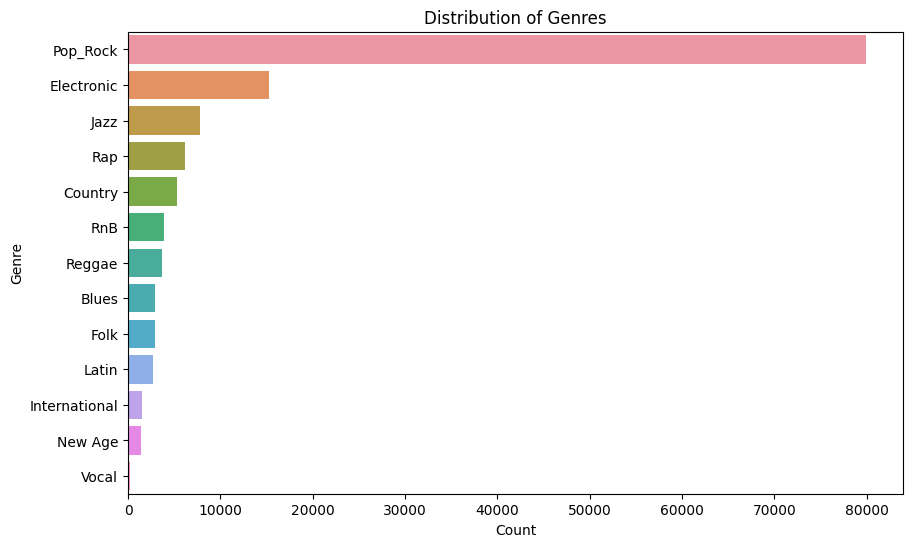

In [56]:
total_genre = genre_df['Genre'].count()
print('Total Genre: ',total_genre)

plt.figure(figsize=(10, 6))
sns.countplot(y='Genre', data=genre_df, order = genre_df['Genre'].value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

## Loading music files

Loading all the .mid files and maping those while with the corresponding genre labels from the above step

In [3]:
# Function to traverse MIDI files in a folder and create a dataframe
def traverse_midi_files(root_dir):
    midi_paths = []
    # Walk through the directory
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.mid') or file.endswith('.midi'):
                # Store the path of the MIDI file
                path = os.path.join(root, file)
                midi_paths.append(path)
    
    # Create a DataFrame from the paths
    midi_df = pd.DataFrame(midi_paths, columns=['File Path'])
    return midi_df

# Function to join MIDI paths with genre data
def join_midi_with_genre(midi_folder, genre_df):
    
    track_ids, file_paths = [], []
    for dir_name, subdir_list, file_list in os.walk(midi_folder):
        if len(dir_name) == 36:
            track_id = dir_name[18:]
            file_path_list = ["/".join([dir_name, file]) for file in file_list]
            for file_path in file_path_list:
                track_ids.append(track_id)
                file_paths.append(file_path)
    all_midi_df = pd.DataFrame({"TrackID": track_ids, "File Path": file_paths})
    df = pd.merge(all_midi_df, genre_df, on='TrackID', how='inner')
    return df.drop(["TrackID"], axis=1)

# Define paths
root_dir = 'lmd_matched'

# Process the MIDI files
midi_df = traverse_midi_files(root_dir)
final_df = join_midi_with_genre(root_dir, genre_df)

print(final_df.head(),  end="\n\n")

                                           File Path     Genre
0  lmd_matched/R/R/U/TRRRUFD12903CD7092/6c460e4c5...  Pop_Rock
1  lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03...  Pop_Rock
2  lmd_matched/R/R/A/TRRRAJP128E0793859/2c78d25cb...       RnB
3  lmd_matched/R/R/F/TRRRFLX128F9326186/afd3595e5...  Pop_Rock
4  lmd_matched/R/R/F/TRRRFLX128F9326186/74582fd38...  Pop_Rock



## Step 2: Extracting features 

In [4]:
def normalize_features(features):
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    return [tempo, resolution, time_sig_1, time_sig_2]

def get_features(file_path):
    """ Extract musical features from a MIDI file. """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        tempo = midi_data.estimate_tempo()
        num_chord_changes = len(midi_data.key_signature_changes)
        resolution = midi_data.resolution
        time_signature = midi_data.time_signature_changes
        ts_1 = 4
        ts_2 = 4
        if len(time_signature) > 0:
            ts_1 = time_signature[0].numerator
            ts_2 = time_signature[0].denominator 
        
        return normalize_features([tempo, num_chord_changes, resolution, ts_1, ts_2])
    except Exception as e:
        return None

def construct_feature_matrix(df):
    """ Construct a matrix of features for all MIDI files listed in the DataFrame. """
    feature_list = []
    for index, row in df.iterrows():
        features = get_features(row['File Path'])
        genre = label_dict[row.Genre]
        if features is not None:
            features.append(genre)
            feature_list.append(features)
    
    return np.array(feature_list)

start_time = datetime.now()
print(start_time)
feature_matrix = construct_feature_matrix(final_df)
print(feature_matrix)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


2024-05-08 11:49:02.909318


/Users/harshshah/anaconda3/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[[ 0.15523849  0.55        0.125       0.125       4.        ]
 [ 0.15523849  0.55        0.125       0.125       4.        ]
 [ 0.06335386 -0.17        0.125       0.125       6.        ]
 ...
 [ 0.43089736  0.55        0.125       0.125       4.        ]
 [ 0.4333338  -0.35        0.125       0.125       4.        ]
 [ 0.41467545  1.91        0.125       0.125       4.        ]]
Duration: 0:43:53.927850


## Heatmap and Sheet notes for a random .mod file

In [24]:
fs = 44100                               
nfft = 2048                             
overlap = 0.5                            # Hop overlap percentage
hop_length = int(nfft*(1-overlap))       # Number of samples between successive frames
n_bins = 72                              # Number of frequency bins
mag_exp = 4                             # Magnitude Exponent
pre_post_max = 6                         # Pre- and post- samples for peak picking
cqt_threshold = -61                      # Threshold for CQT dB levels, all values below threshold are set to -120 dB
plt.rc("figure", figsize=(16, 8))

# converted one .mid file to mp3 for plotting
filename = r"0af0df4402e10bd4c8b27305152e94d8.mp3"
x, fs = librosa.load(filename, sr=None, mono=True, duration=13
                    )
print("x Shape=", x.shape)
print("Sample rate fs=", fs)
print("Audio Length in seconds=%d [s]" % (x.shape[0]/fs))

ipd.Audio(x, rate=fs)




x Shape= (573300,)
Sample rate fs= 44100
Audio Length in seconds=13 [s]


## Power Spectrum of the audiofile

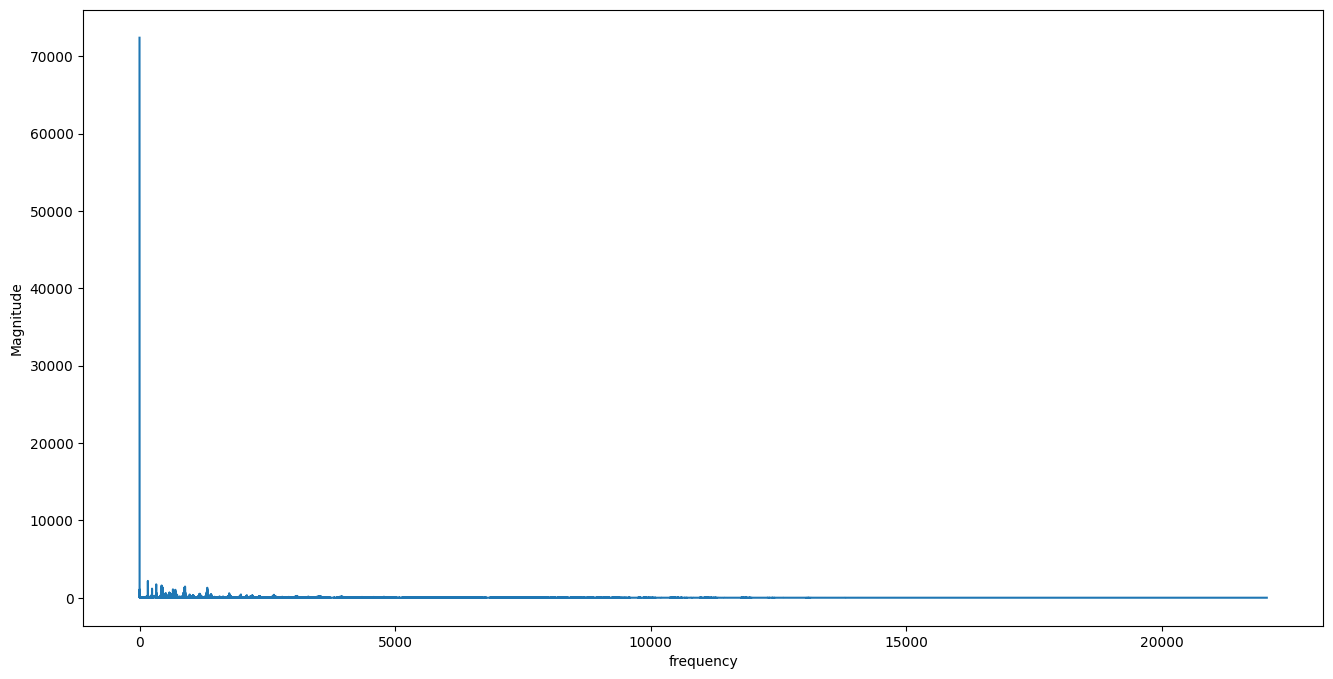

In [76]:
signal, sr = librosa.load(filename, sr=None, mono=True, duration=30)
fft= np.fft.fft(signal)
magnitude= np.abs(fft)
frequency= np.linspace(0, sr, len(magnitude))
left_frequency= frequency[:int(len(frequency)/2)]
left_magnitude= magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel('frequency')
plt.ylabel('Magnitude')
plt.show()

In [25]:

# CQT vs FFT

# CQT Frequencies
cqt_freqs = librosa.core.cqt_frequencies(n_bins=128, fmin=librosa.note_to_hz('C0'), bins_per_octave=12)

# FFT Frequencies
fft_freqs = librosa.fft_frequencies(sr=44100, n_fft=128)

# Notes Center Frequencies
notes_freqs = 440*2**(np.arange(-57, (128-57))/12)

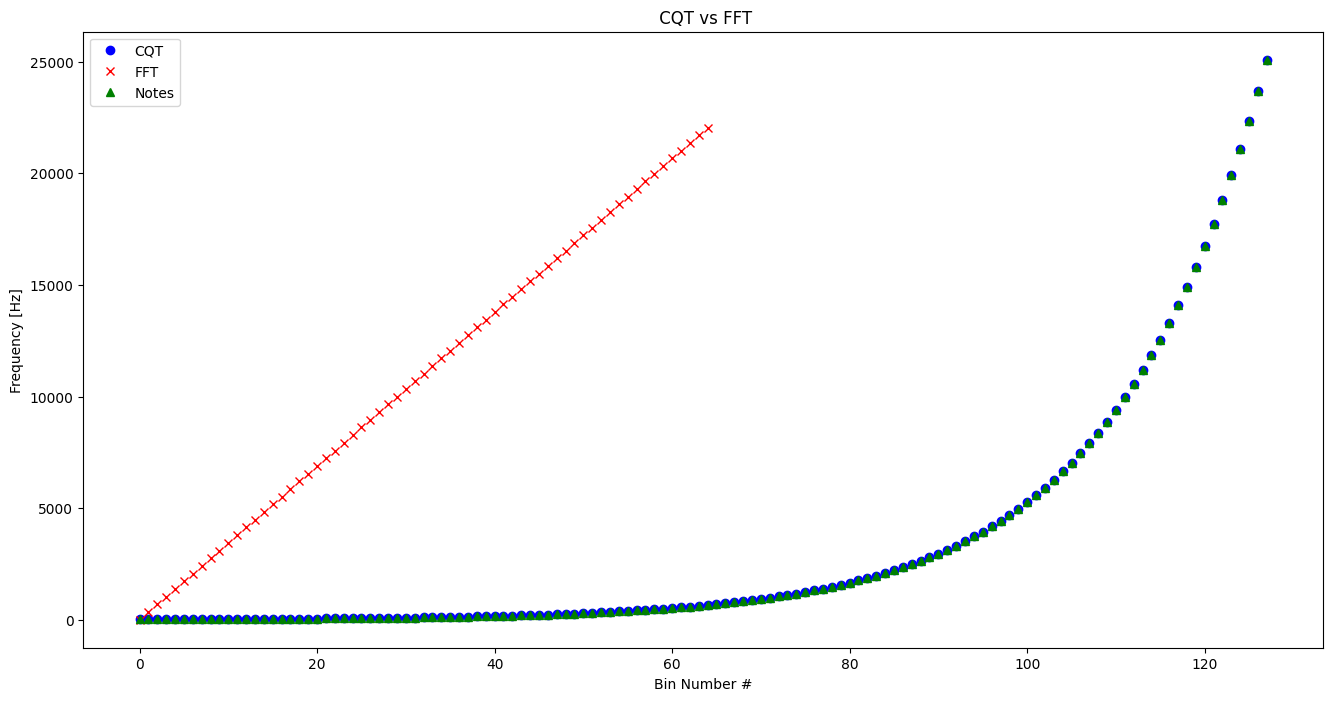

In [26]:
plt.figure()
plt.plot(cqt_freqs, 'bo', label='CQT')
plt.plot(fft_freqs, 'rx', label= 'FFT')
plt.plot(notes_freqs, 'g^', label = 'Notes')
plt.title(" CQT vs FFT")
plt.xlabel('Bin Number #')
plt.ylabel('Frequency [Hz]')
plt.legend();

In [38]:
def calc_cqt(x,fs=fs,hop_length=hop_length, n_bins=n_bins, mag_exp=mag_exp):
    C = librosa.cqt(x, sr=fs, hop_length=hop_length, fmin=None, n_bins=n_bins)
    C_mag = librosa.magphase(C)[0]**mag_exp
    CdB = librosa.core.amplitude_to_db(C_mag ,ref=np.max)
    return CdB

def cqt_thresholded(cqt,thres=cqt_threshold):
    new_cqt=np.copy(cqt)
    new_cqt[new_cqt<thres]=-120
    return new_cqt

def calc_onset_env(cqt):
    return librosa.onset.onset_strength(S=cqt, sr=fs, aggregate=np.mean, hop_length=hop_length)

def calc_onset(cqt, pre_post_max=pre_post_max, backtrack=True):
    onset_env=calc_onset_env(cqt)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                           sr=fs, units='frames', 
                                           hop_length=hop_length, 
                                           backtrack=backtrack,
                                           pre_max=pre_post_max,
                                           post_max=pre_post_max)
    onset_boundaries = np.concatenate([[0], onset_frames, [cqt.shape[1]]])
    onset_times = librosa.frames_to_time(onset_boundaries, sr=fs, hop_length=hop_length)
    return [onset_times, onset_boundaries, onset_env]


style = {'description_width': 'initial'}
mag_exp_slider=IntSlider(value=mag_exp, min=1, max=32, step=1, 
                         description='mag_exp:',continuous_update=False)

thres_slider=IntSlider(value=cqt_threshold, min=-120, max=0, step=1, 
                                                     description='Threshold:',continuous_update=False)

pre_post_slider=IntSlider(value=pre_post_max, min=1, max=32, step=1, 
                         description='Pre_post_max:',continuous_update=False, style=style)

backtrack_box=Checkbox(value=False,description='backtrack',disabled=False)


def inter_cqt_tuning(mag_exp,thres,pre_post_max, backtrack):
    thres=thres_slider.value
    mag_exp=mag_exp_slider.value
    pre_post_max=pre_post_slider.value
    backtrack=backtrack_box.value
    global CdB
    CdB = calc_cqt(x,fs,hop_length, n_bins, mag_exp)
    plt.figure()
    new_cqt=cqt_thresholded(CdB,thres)
    librosa.display.specshow(new_cqt, sr=fs, hop_length=hop_length, x_axis='time', y_axis='cqt_note', cmap='coolwarm')
    plt.ylim([librosa.note_to_hz('B2'),librosa.note_to_hz('B6')])
    global onsets
    onsets=calc_onset(new_cqt,pre_post_max, backtrack)
    plt.vlines(onsets[0], 0, fs/2, color='k', alpha=0.8)
    plt.title("CQT - Sample audio")
    plt.colorbar()
    plt.show()
    

In [39]:
out = interactive_output(inter_cqt_tuning,  {'mag_exp': mag_exp_slider, 'thres': thres_slider, 
                                             'pre_post_max': pre_post_slider, 'backtrack':backtrack_box})
ui = VBox([mag_exp_slider, thres_slider, pre_post_slider, backtrack_box])
display(ui, out)

Output()

## Extracting Sheet notes

In [79]:
tempo, beats=librosa.beat.beat_track(y=None, sr=fs, onset_envelope=onsets[2], hop_length=hop_length,
               start_bpm=130.0, tightness=100, trim=True, bpm=None,
               units='frames')
tempo=int(2*round(tempo/2))
mm = MetronomeMark(referent='quarter', number=tempo)
print("tempo:", tempo)

tempo: 144


In [81]:
def time_to_beat(duration, tempo):
    return (tempo*duration/60)

# Remap input to 0-1 for Sine Amplitude or to 0-127 for MIDI
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def generate_note(f0_info, sr, n_duration, round_to_sixtenth=True):
    f0=f0_info[0]
    A=remap(f0_info[1], CdB.min(), CdB.max(), 0, 1)
    duration = librosa.frames_to_time(n_duration, sr=fs, hop_length=hop_length)
    note_duration = 0.02*np.around(duration/2/0.02)
    midi_duration = time_to_beat(duration, tempo)
    midi_velocity=int(round(remap(f0_info[1], CdB.min(), CdB.max(), 0, 127)))
    if round_to_sixtenth:
        midi_duration=round(midi_duration*16)/16
    if f0==None:
        midi_note=None
        f0=0
    else:
        midi_note=round(librosa.hz_to_midi(f0))
        note = Note(librosa.midi_to_note(midi_note).replace('♯','#')#, type=mm.secondsToDuration(note_duration).type
                   )
        note.volume.velocity = midi_velocity
        note_info = [note]
    midi_info = [midi_note, midi_duration, midi_velocity]
            
    return note_info

def estimate_pitch(segment, threshold):
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=librosa.note_to_hz('C1'),
                            bins_per_octave=12)
    if segment.max()<threshold:
        return [None, np.mean((np.amax(segment,axis=0)))]
    else:
        f0 = int(np.mean((np.argmax(segment,axis=0))))
    return [freqs[f0], np.mean((np.amax(segment,axis=0)))]

def estimate_pitch_and_notes(x, onset_boundaries, i, sr):
    n0 = onset_boundaries[i]
    n1 = onset_boundaries[i+1]
    f0_info = estimate_pitch(np.mean(x[:,n0:n1],axis=1),threshold=cqt_threshold)
    return generate_note(f0_info, sr, n0)

In [82]:
Num= len(onsets[1]-1)
for i in range(Num):
    try:
        print(estimate_pitch_and_notes(CdB, onsets[1], i, sr=fs))
    except:
        print("Rest")

Rest
[<music21.note.Note A>]
[<music21.note.Note A>]
Rest
[<music21.note.Note A>]
Rest
Rest
[<music21.note.Note A>]
[<music21.note.Note F>]
[<music21.note.Note F>]
[<music21.note.Note F>]
Rest
[<music21.note.Note F>]
[<music21.note.Note A>]
[<music21.note.Note A>]
Rest
[<music21.note.Note A>]
Rest
[<music21.note.Note A>]
[<music21.note.Note A>]
[<music21.note.Note D>]
[<music21.note.Note A>]
Rest
Rest
[<music21.note.Note A>]
[<music21.note.Note A>]
[<music21.note.Note A>]
Rest


In [46]:
# Load the MIDI file
midi_path = 'lmd_matched/S/J/S/TRSJSLS12903CCCE89/a7fda41b8e55664cf1bdc5e1ac79ec83.mid'
midi_file = MidiFile(midi_path)

# Extract notes and other information
notes = []
for track in midi_file.tracks:
    for msg in track:
        if not msg.is_meta and msg.type == 'note_on':
            note_info = {
                'track': track.name,
                'note': msg.note,
                'velocity': msg.velocity,
                'time': msg.time
            }
            notes.append(note_info)

notes[:10]  # Display the first 10 notes to get a sense of the data


[{'track': '', 'note': 43, 'velocity': 122, 'time': 167},
 {'track': '', 'note': 47, 'velocity': 122, 'time': 1},
 {'track': '', 'note': 50, 'velocity': 122, 'time': 1},
 {'track': '', 'note': 43, 'velocity': 104, 'time': 2},
 {'track': '', 'note': 55, 'velocity': 122, 'time': 0},
 {'track': '', 'note': 59, 'velocity': 42, 'time': 0},
 {'track': '', 'note': 62, 'velocity': 43, 'time': 0},
 {'track': '', 'note': 67, 'velocity': 41, 'time': 0},
 {'track': '', 'note': 59, 'velocity': 122, 'time': 1},
 {'track': '', 'note': 67, 'velocity': 122, 'time': 1}]

In [41]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

## Step 3: Partition Dataset 

In this step, we will partition the data set so that 60% of it is used for training the data, 20% is used for validation (to tune the hyperparameters of the neural network), and the remaining 20% is used as the testing set to report our accuracy

In [57]:
def prepare_dataset(features, labels):

    labeled_features = np.random.permutation(features)

    # Partition into 3 Sets
    num = len(labeled_features)
    num_training = int(num * 0.6)
    num_validation = int(num * 0.8)
    training_data = labeled_features[:num_training]
    validation_data = labeled_features[num_training:num_validation]
    test_data = labeled_features[num_validation:]

    # Separate Features from Labels
    num_cols = training_data.shape[1] - 1
    training_features = training_data[:, :num_cols]
    validation_features = validation_data[:, :num_cols]
    test_features = test_data[:, :num_cols]

    # Format Features for Multi-class Classification
    num_classes = len(label_list)
    training_labels = training_data[:, num_cols].astype(int)
    validation_labels = validation_data[:, num_cols].astype(int)
    test_labels = test_data[:, num_cols].astype(int)
    
    return training_features, validation_features, test_features, training_labels, validation_labels, test_labels


def one_hot_encode_labels(labels):
    # One-hot encode labels
    encoder = OneHotEncoder(sparse=False)
    labels = labels.reshape(-1, 1)
    one_hot_encoded_labels = encoder.fit_transform(labels)
    return one_hot_encoded_labels

# Assuming the labels are in the 'Genre' column of genre_df
labels = genre_df['Genre'].values

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(feature_matrix, labels)

# Encode the labels
y_train_encoded = one_hot_encode_labels(y_train)
y_val_encoded = one_hot_encode_labels(y_val)
y_test_encoded = one_hot_encode_labels(y_test)

# Check shapes to confirm everything is as expected
print(f"Training features shape: {X_train.shape}, Training labels shape: {y_train_encoded.shape}")
print(f"Validation features shape: {X_val.shape}, Validation labels shape: {y_val_encoded.shape}")
print(f"Testing features shape: {X_test.shape}, Testing labels shape: {y_test_encoded.shape}")


Training features shape: (7956, 4), Training labels shape: (7956, 13)
Validation features shape: (2652, 4), Validation labels shape: (2652, 13)
Testing features shape: (2652, 4), Testing labels shape: (2652, 13)


/Users/harshshah/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/harshshah/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/harshshah/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Step 4: Model construction

We used MLP, SVM and CNN to compare the accuracy of the labels, pick the best model and return the classifier that performed best on the validation set.

In [60]:
# Define the models
mlp = MLPClassifier(max_iter=1000)  # Increased max_iter for convergence
svc = SVC()

# Hyperparameters to tune
mlp_params = {
    'hidden_layer_sizes': [(5,), (5, 5),(10, 10), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [1e-4, 1e-5]
}

svc_params = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid search setup for MLP
mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=3, scoring='accuracy', verbose=1)

# Grid search setup for SVC
svc_grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, scoring='accuracy', verbose=1)

# Fit the models on the validation set to tune the hyperparameters
print("Tuning MLP...")
mlp_grid.fit(X_val, y_val)
print("Best MLP parameters:", mlp_grid.best_params_)

print("Tuning SVC...")
svc_grid.fit(X_val, y_val)
print("Best SVC parameters:", svc_grid.best_params_)

# Select the best model based on the validation set
best_mlp_score = mlp_grid.best_score_
best_svc_score = svc_grid.best_score_

if best_mlp_score > best_svc_score:
    print("MLP performed better on the validation set.")
    best_model = mlp_grid.best_estimator_
else:
    print("SVC performed better on the validation set.")
    best_model = svc_grid.best_estimator_

best_model


Tuning MLP...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best MLP parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'solver': 'sgd'}
Tuning SVC...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best SVC parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
SVC performed better on the validation set.


SVC(C=0.01, kernel='linear')

In [62]:
mlp_grid

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 1e-05],
                         'hidden_layer_sizes': [(5,), (5, 5), (10, 10),
                                                (100, 100)],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

In [63]:
svc_grid

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [74]:
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the model on the test set
test_accuracy_svc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy for SVC: {test_accuracy_svc:.2f}")


Test Accuracy for SVC: 0.73


## CNN model

In [67]:
X_train_cnn = X_train.reshape((-1, 4, 1))
X_val_cnn = X_val.reshape((-1, 4, 1))
X_test_cnn = X_test.reshape((-1, 4, 1))

# Confirm the new shape
print("Updated training data shape:", X_train.shape)


Updated training data shape: (7956, 4)


In [68]:
num_classes = y_train_encoded.shape[1]

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(4, 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 



/Users/harshshah/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,085 (12.05 KB)

 Trainable params: 3,085 (12.05 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:

history = model.fit(X_train_cnn, y_train_encoded, epochs=10, validation_data=(X_val_cnn, y_val_encoded))

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.7016 - loss: 1.7129 - val_accuracy: 0.7285 - val_loss: 1.1456
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7443 - loss: 1.0834 - val_accuracy: 0.7285 - val_loss: 1.1401
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.7466 - loss: 1.0789 - val_accuracy: 0.7285 - val_loss: 1.1379
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7473 - loss: 1.0766 - val_accuracy: 0.7285 - val_loss: 1.1541
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.7487 - loss: 1.0633 - val_accuracy: 0.7285 - val_loss: 1.1353
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7527 - loss: 1.0677 - val_accuracy: 0.7285 - val_loss: 1.1362
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7470 - loss: 1.0733 - val_accuracy: 0.7285 - val_loss: 1.1312
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7473 - loss: 1.0695 - 

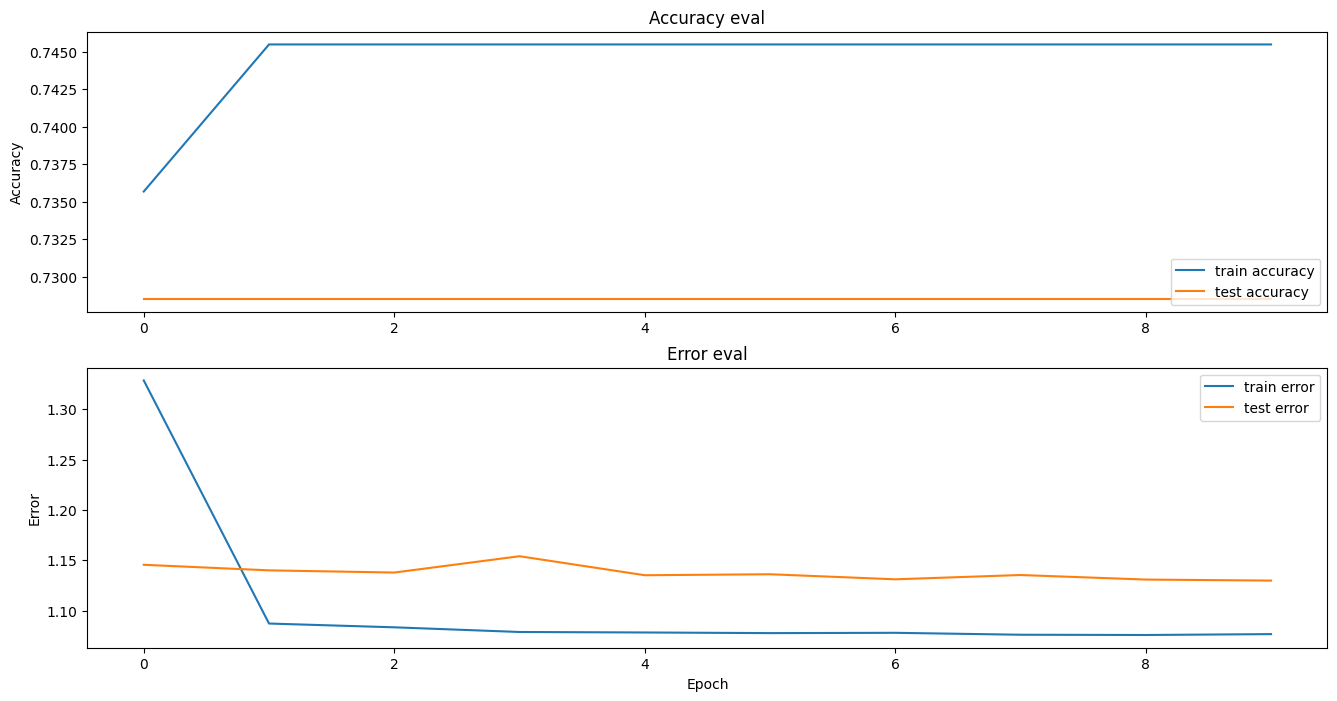

In [70]:
plot_history(history)

In [75]:
# Evaluate the model on the test set
test_loss_cnn, test_accuracy_cnn = model.evaluate(X_test_cnn, y_test_encoded)
print(f"Test Accuracy for CNN: {test_accuracy:.2f}")


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - accuracy: 0.7233 - loss: 1.1408
Test Accuracy for CNN: 0.74


In [72]:
if test_accuracy_svc > test_accuracy_cnn:
    print("SVC performed better on the validation set.")
    final_model = best_model
else:
    print("CNN performed better on the validation set.")
    final_model = model

SVC performed better on the validation set.


## Step 5: Prediction on a Midi File

In [73]:
# midi_file_path = 'lmd_matched/R/R/I/TRRRION128F145EBB7/9048c4045d7d8b2837f3725d7995dc1c.mid'
midi_file_path = 'lmd_matched/S/J/S/TRSJSLS12903CCCE89/a7fda41b8e55664cf1bdc5e1ac79ec83.mid'

# Extract features
features = get_features(midi_file_path)
predicted_genre = labels[list(final_model.predict([features]))]

print(f"The predicted genre of the MIDI file is:\n {predicted_genre[0]}")


The predicted genre of the MIDI file is:
 Pop_Rock
